In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



from pymdp.agent import Agent
from pymdp import utils
from pymdp import maths


def softmax_t(dist, c = 5):
    """ 
    Computes the softmax function on a set of values, with an inverse temperature parameter c
    """
    T = 1/c
    output = dist - dist.max(axis=0)
    output = np.exp(output/T)
    output = output / np.sum(output, axis=0)
    return output

In [9]:
def generateObs():
    """
    Generate the indeces of the three obervations: Other, Self, Location
    """
    o = [0,0,0]

    if TrueLocation[0] == 1: #Mirror
        if TrueFace[0] == 1: #Smile
            o[0] = 0  #Smile
            o[1] = 0  #Smile
            o[2] = 0  #Mirror
        if TrueFace[1] == 1: #Neutral
            o[0] = 1          
            o[1] = 1
            o[2] = 0
        if TrueFace[2] == 1:#Frown
            o[0] = 2
            o[1] = 2
            o[2] = 0
    if TrueLocation[1] == 1: #Wall
        if TrueFace[0] == 1: #Smile
            o[0] = 3         #None
            o[1] = 0         
            o[2] = 1
        if TrueFace[1] == 1: #Neutral
            o[0] = 3
            o[1] = 1
            o[2] = 1
        if TrueFace[2] == 1: #Frown
            o[0] = 3  
            o[1] = 2
            o[2] = 1
    if TrueLocation[2] == 1: #Video
        if TrueFace[0] == 1: #Smile
            #A random observation that is not contingent to the agents face
            o[0] = int(np.random.choice(3, 1, p=[0.0, 0.5, 0.5]))
            o[1] = 0
            o[2] = 2
        if TrueFace[1] == 1: #Neutral
            o[0] = int(np.random.choice(3, 1, p=[0.5, 0.0, 0.5]))    
            o[1] = 1
            o[2] = 2
        if TrueFace[2] == 1: #Frown
            o[0] = int(np.random.choice(3, 1, p=[0.5, 0.5, 0]))
            o[1] = 2
            o[2] = 2
    return o         

In [10]:
"""A Matrices"""
#modality exteroceptive O[Smile, Neutral, Frown, None]: 
A1 = np.zeros((4,3,3,3,2))     #A[observations, Location, Other, Self, Attention]

for j in range(2):
    for i in range(3):
        if j == 1:     #If paying attention agent knows exteroceptive observation shows information abt herself 
            for l in range(3):
                if l == 1:
                    A1[:,l,i,0,j] = [0.01, 0.01, 0.01, 0.97]  #Wall will just give observation None
                    A1[:,l,i,1,j] = [0.01, 0.01, 0.01, 0.97]  
                    A1[:,l,i,2,j] = [0.01, 0.01, 0.01, 0.97]  
                else:
                    A1[:,l,0,0,j] = [0.97, 0.01, 0.01, 0.01]  #If I smile I will observe smile
                    A1[:,l,1,0,j] = [0.97, 0.01, 0.01, 0.01]  
                    A1[:,l,2,0,j] = [0.97, 0.01, 0.01, 0.01]  
                    
                    
                    A1[:,l,0,1,j] = [0.01, 0.97, 0.01, 0.01]  # If I am neutral I will observe neutral
                    A1[:,l,1,1,j] = [0.01, 0.97, 0.01, 0.01]  
                    A1[:,l,2,1,j] = [0.01, 0.97, 0.01, 0.01]  
                    
                    A1[:,l,0,2,j] = [0.01, 0.01, 0.97, 0.01]  # If I frown I will observer frown
                    A1[:,l,1,2,j] = [0.01, 0.01, 0.97, 0.01]  
                    A1[:,l,2,2,j] = [0.01, 0.01, 0.97, 0.01]
                        
        else:    #Agent is not paying attention
            #Mirror
            A1[:,0,0,i,j] = [0.97, 0.01, 0.01, 0.01]  # observation relates to the state of the other 
            A1[:,0,1,i,j] = [0.01, 0.97, 0.01, 0.01]  # now instead giving information about my own state
            A1[:,0,2,i,j] = [0.01, 0.01, 0.97, 0.01]
            #Video
            A1[:,2,0,0,j] = [0.97, 0.01, 0.01, 0.01]   
            A1[:,2,1,0,j] = [0.01, 0.97, 0.01, 0.01]  
            A1[:,2,2,0,j] = [0.01, 0.01, 0.97, 0.01]  
            
            A1[:,2,0,1,j] = [0.97, 0.01, 0.01, 0.01] 
            A1[:,2,1,1,j] = [0.01, 0.97, 0.01, 0.01]  
            A1[:,2,2,1,j] = [0.01, 0.01, 0.97, 0.01]  

            A1[:,2,0,2,j] = [0.97, 0.01, 0.01, 0.01]  
            A1[:,2,1,2,j] = [0.01, 0.97, 0.01, 0.01] 
            A1[:,2,2,2,j] = [0.01, 0.01, 0.97, 0.01]  
            
            ##Wall
            A1[:,1,0,i,j] = [0.01, 0.01, 0.01, 0.97]  # Wall still gives obs none
            A1[:,1,1,i,j] = [0.01, 0.01, 0.01, 0.97]  
            A1[:,1,2,i,j] = [0.01, 0.01, 0.01, 0.97]  



#modality interoceptive O[Smile, Neutral, Frown]
A2 = np.zeros((3,3,3,3,2))   #A[observations, Location, Other, Self, Attention]

#Precise Mapping A if paying attention, otherwise internal observations carry no information due to high entropy
c = 0
for j in range(2):
    for i in range(3):
        for l in range(3):
            if j == 0:   #if not paying attention set inverse T low --> high entropy in A
                c = 0.001
            else:
                c = 5 #paying attention set inverse T high --> low entropy, precise A
            A2[:,l,i,0,j] = softmax_t(np.array([0.98, 0.01, 0.01]), c)  # state Me: Smile
            A2[:,l,i,1,j] = softmax_t(np.array([0.01, 0.98, 0.01]), c)  # Neutral
            A2[:,l,i,2,j] = softmax_t(np.array([0.01, 0.01, 0.98]), c)  # Frown


#Modality Location: 1 to 1 mapping, agent always knows where she is.            
A3 = np.zeros((3,3,3,3,2)) 

for j in range(2):
    for i in range(3):
        for l in range(3):
            A3[:,0,i,l,j] = [1, 0 , 0]
            A3[:,1,i,l,j] = [0, 1 , 0]
            A3[:,2,i,l,j] = [0, 0 , 1]

            
num_states = [3,3,3,2]
num_factors = 4
num_obs = [4,3,3]

#Format A tensor for pymdp framework
A = utils.obj_array_zeros([ [obs_dim] + num_states for _, obs_dim in enumerate(num_obs)] )

A[0] = A1
A[1] = A2
A[2] = A3

"""B MATRICES"""

BLoc = np.zeros((3,3,3))
            #M W V
BLoc[0,:,0]=[1,1,1]  #M           ###going towards Mirror
BLoc[1,:,0]=[0,0,0]  #W         
BLoc[2,:,0]=[0,0,0]  #V   

BLoc[0,:,1]=[0,0,0]  #M           ###going towards Wall
BLoc[1,:,1]=[1,1,1] #W         
BLoc[2,:,1]=[0,0,0]  #V     

BLoc[0,:,2]=[0,0,0]  #M           ###going towards Video
BLoc[1,:,2]=[0,0,0]  #W         
BLoc[2,:,2]=[1,1,1]  #V     
    
      
BFace = np.zeros((3,3,1))     
          
BFace[0,:,0]=[0.95,0.025,0.025]  #Smiling      
BFace[1,:,0]=[0.025,0.95,0.025]  #Neutral         
BFace[2,:,0]=[0.025,0.025,0.95]  #Frown 


BOther = np.zeros((3,3,1))     
              #S     N     F
BOther[0,:,0]=[0.8, 0.1, 0.1]  #Smiling      
BOther[1,:,0]=[0.1, 0.8, 0.1]  #Neutral         
BOther[2,:,0]=[0.1, 0.1, 0.8] #Frown 

#So the agent can infer the property of the mirror -making me pay attention- also over time
BAttention = np.zeros((2,2,2))

BAttention[0,:,0] = [1, 1]
BAttention[1,:,0] = [0, 0]

BAttention[0,:,1] = [0, 0]
BAttention[1,:,1] = [1, 1]


B = utils.obj_array(num_factors)
B[0] = BLoc
B[1] = BOther #_precision 
B[2] = BFace #_precision
B[3] = BAttention

"""C MATRICES"""
#Preferences
C = utils.obj_array_zeros([num_ob for num_ob in num_obs])
C[0][0] = 0.0   #  See other smile
C[0][1] = 0.0   # See other neutral
C[0][2] = 0.0  #See other frown
C[0][3] = 0.0  # see None
C[1][0] = 3.0  #self smile
C[1][1] = 3.0  #self neutral
C[1][2] = 0.0  #self frown


"""D Matrices"""
prior = utils.obj_array(num_factors)

prior[0] = maths.softmax(np.array([1, 1, 1])) #prior over Loc [Mirror, Wall, Video]
prior[1] = np.array([0.98, 0.01, 0.01]) #maths.softmax(np.array([1, 1, 1])) #prior over other face expression [Smile ,Neutral, Frown]
prior[2] = np.array([0.01, 0.01, 0.98]) # prior over own face  [Smile ,Neutral, Frown]
prior[3] = np.array([0.99,0.01])        # prior over attention [No attention, Attention]
log_c = np.exp(-16)

"""POLICIES"""
#Policies: Go MW, MV, MM, WW, WV, WM, VM, VW, VV
pol = [np.array([[0,0,0,1],[0,0,0,1]]),np.array([[0,0,0,1],[1,0,0,0]]),np.array([[0,0,0,1],[2,0,0,0]]),
       np.array([[1,0,0,0],[0,0,0,1]]),np.array([[1,0,0,0],[2,0,0,0]]),np.array([[1,0,0,0],[1,0,0,0]]),
       np.array([[2,0,0,0],[0,0,0,1]]),np.array([[2,0,0,0],[1,0,0,0]]), np.array([[2,0,0,0],[2,0,0,0]])]


"""SECOND LAYER"""
Trials = 8

S2Face = np.zeros((3,Trials))

for trial in range(Trials):
    #[Happy, Neutral, Sad]
    S2Face[:,trial] =  np.array([0.01, 0.01, 0.98]) #change here to change starting condition of knowing about own emotional state
    
S2A = np.zeros((2,Trials))  #AFFECT: [positive valence, negative valence]
S2A[:,0] = np.array([0.5, 0.5])

A2F = np.zeros((3,3)) #Mapping between Second Layer and First layer, S2Face -> S1Face, Mood->emotion

A2F[0,:] = [1, 0, 0]
A2F[1,:] = [0, 1, 0]
A2F[2,:] = [0, 0, 1]

A2A = np.zeros((2,2))   #Mapping Affect and AC see Hesp et al. 2021 

A2A[0,:] = [0.97, 0.03]
A2A[1,:] = [0.03, 0.97]

B2A = np.zeros((2,2)) #Transition matrix of Affect on second level
B2A[0,:] = [0.8, 0.3]
B2A[1,:] = [0.2, 0.7]

B2F = np.zeros((3,3)) #Transition matrix of S2Face on second level
B2F[0,:] = [1, 0, 0]
B2F[1,:] = [0, 1, 0]
B2F[2,:] = [0, 0, 1]


Beta_plus_minus = np.array([0.5, 2]) #upper and lower bounds for gamma 
AC = 0.5 #Affective Charge

"""PRECISION ON A2"""
A2F = softmax_t(A2F, 1) #Activate this to set precision on A2F c = 5 high, c = 1 low
A2F

array([[0.57611688, 0.21194156, 0.21194156],
       [0.21194156, 0.57611688, 0.21194156],
       [0.21194156, 0.21194156, 0.57611688]])

In [11]:
"""Some plotting funcitons"""

def plot_states (qs, labels = None):
    #qs consists of states at time tau, for each factor qs[t][f], T = Trial
            
    fig, axes = plt.subplots(len(qs),len(qs[0]), figsize=(11, 10))
    for i, ax in enumerate(axes):
        for j, _ in enumerate(ax):
            
            
            ax[j].bar(range(int(len(qs[i][j]))), qs[i][j], color = 'Red')
            ax[j].set_ylabel('Time point '+ str(i))
            if labels == None:
                ax[j].set_title('Factor ' + str(j))
            else:
                ax[j].set_title(labels[j])    
            
          
    plt.show()
    
def plot_beliefs(belief_dist, ax, title = ""):
    ax.grid(zorder=0)
    ax.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3, alpha = 0.9)
    #ax.xticks(range(belief_dist.shape[0]))
  
    
def plot_policies(pol): 
    fig = plt.figure(figsize=(4,4))
    plt.bar(range(len(pol)), pol, color = 'blue')
    plt.title('Policy probabilities')
    plt.show()    

In [24]:
"""Setup"""
"""!! The inference horizon in algos mmp.py is set manually as follows:  
    future_cutoff = 2
    infer_len = 3"""
#setup agent in pymdp infer-actively
gamma = 1.0 #precision on G
agent = Agent(A = A, B= B, C=C, D=prior, policy_len = 2, policies = pol, control_fac_idx = [0, 3], inference_horizon = 3, inference_algo='MMP', gamma = gamma)
T = 3# number of timesteps in trial
TrueLocation = [0,1,0] #[M, W, V]
TrueFace =     [0,0,1] #[S, N, F]
AC = np.zeros(T-1) #keep track of AC in one trial
posterior_beta = 1
beta = 1 

# these are useful for displaying read-outs during the loop over time
location_observations = ['MIRROR','WALL','VIDEO']
ex_observations =       ['SMILE','NEUTRAL','FROWN', 'NONE']
in_observations =       ['SMILE','NEUTRAL','FROWN']
trueState = ['HAPPY', 'NEUTRAL', 'SAD']

n_policies = len(pol)
#initiate Bayesian model average
BMA = [np.zeros((num_factors), dtype = object) for i in range(3)] #range(3) is the inference horizon! 


listFaceBMA = [] #keep track of average beliefs

pols = [[] for trial in range(Trials)] # keep track of policies chosen
TrueFaces = []  #keep track of changes in the true state

DLearn = np.ones((3,Trials))      #Use accumulative learning instead of second layer, currently not used!
DLearn[:, 0] = [0.98,0.01,0.01]

"""MAIN LOOP"""
for trial in range(Trials):

    print('-----Trial: ', trial, ' ---------')

    #Dynamics of true state changing:
    
    if trial >= 1 and trial < 8:
        if S2A[:,trial][0] >= 0.7:
            TrueFace = [1,0,0]
        elif np.abs(S2A[:,trial][0] - S2A[:,trial-1][0]) > 0.15 and S2A[:,trial][0] < 0.4:
            TrueFace = [0,0,1]
        elif np.abs(S2A[:,trial][0] - S2A[:,trial-1][0]) > 0.15 and S2A[:,trial][0] < 0.7:
            TrueFace = [0,1,0]
        
        
    TrueFaces.append(np.where(np.array(TrueFace)==1)[0][0])
    
    # Descending message: S2Face sets prior for face on the first level
    
    prior_face = A2F.dot(S2Face[:,trial]) #maths.softmax(DLearn[:,trial]) use for acc learning
    
    # Descending message: Affect influences gamma
    gamma = 1/(Beta_plus_minus.dot(A2A.dot(S2A[:,trial])))
    
    #reset agent with new priors
    prior[2] = prior_face
    agent = Agent(A = A, B= B, C=C, D=prior, policy_len = 2, 
                  policies = pol, control_fac_idx = [0, 3], inference_horizon = 3, inference_algo='MMP', gamma = gamma)
 
    #Trial begins
    for t in range(T):
        #reset BMA
        BMA[0][:] = 0  
        BMA[1][:] = 0
        BMA[2][:] = 0

        O = generateObs() #get observation
        
        print('True emotional state: ', trueState[int(np.where(np.array(TrueFace) == 1)[0][0])])
        msg= """External Obs: {} Internal Obs: {} Location Obs: {} """
        print(msg.format(ex_observations[O[0]], in_observations[O[1]], location_observations[O[2]]))      
        
        qs_pol = agent.infer_states(O) #perform inference via marginal message passing

        n_policies = len(agent.policies) # number of policies

        qs_pi = utils.obj_array(n_policies) # we are initializing a new qs_pi array to contain just the beliefs you're interested in


        start_tstep = max(0, agent.curr_timestep - agent.inference_horizon) # this is the first timestep of the agent's inference horizon, from the perspective of the current timestep (lower bounded by beginning of trial)
        end_tstep = min(agent.curr_timestep + agent.policy_len+1, T) # this is the last timestep of the agent's inference horizon, from the perspective of the current timestep (upper bounded by the end of the trial)


        for p in range(n_policies):

            qs_pi[p] = qs_pol[p][start_tstep:end_tstep] # extract just the timesteps you want from the original array. Those indices should get just the forward and backwards beliefs from the perspective of the current timestep 


        q_pi, efe = agent.infer_policies() #infer policies by calculating expected free energy
        policy_prior = maths.softmax(gamma*efe)
        #plot_policies(agent.q_pi)
        

        #calculate bayesian model average (summing out policies to get the average belief about states)
        for tau in range(len(qs_pi[0])):
            for factor in range(len(qs_pi[0][0])):
                for n_pol in range(n_policies):
                    BMA[tau][factor] += q_pi[n_pol] * qs_pi[n_pol][tau][factor]

        #plot_states(BMA, ["Location", "Other FACE", "My FACE", "Attention"])      
        if t ==0:
            listFaceBMA.append(BMA[0][2])
        
        #Perform action
        if t < T-1:
            action = agent.sample_action()

            msg = """[Step {}] Action: [Move to {}] \n"""
            print(msg.format(t, location_observations[int(action[0])]))


            #print('action: ', action)

            TrueLocation = np.inner(B[0][:,:,int(action[0])], TrueLocation)
            
            #calculate Affective charge and update gamma
            AC[t] = np.sum((q_pi-policy_prior).T * efe)
            beta_posterior = beta - AC[t]
            gamma = 1/beta_posterior
            agent.gamma = gamma
            #print('gamma: ' ,gamma)
            #track actions
            pols[trial].append(action[0])

        msg = """[Policy {}] [Move to {} and {}] [F {}] [G {}]"""
        F = agent.F
        """
        #to pringt our G and F for each policy
        for idx, p in enumerate(agent.policies):
            print(msg.format(idx, location_observations[p[0][0]],location_observations[p[1][0]], F[idx], efe[idx]))
        """
    #trial ends    
    print('AC: ', AC)
    
    #at the end of trial update second order states
    if trial < Trials-1:
        #Ascending Mesages
        S2A[:,trial+1] = maths.softmax(B2A[:,:].dot(S2A[:,trial]) - np.log(((Beta_plus_minus - AC[-1])/Beta_plus_minus) * (beta/ (beta-AC[-1]))+log_c))
        S2Face[:,trial+1] = maths.softmax(B2F[:,:].dot(S2Face[:,trial]) + np.log(A2F.dot(BMA[2][2])+log_c))
        #DLearn[:,trial+1] = 0.9*DLearn[:,trial] + 0.3 * BMA[0][2] #for acc learning

-----Trial:  0  ---------
True emotional state:  SAD
External Obs: NONE Internal Obs: FROWN Location Obs: WALL 
[Step 0] Action: [Move to VIDEO] 

True emotional state:  SAD
External Obs: NEUTRAL Internal Obs: FROWN Location Obs: VIDEO 
[Step 1] Action: [Move to VIDEO] 

True emotional state:  SAD
External Obs: SMILE Internal Obs: FROWN Location Obs: VIDEO 
AC:  [1.07769798e-15 1.52348089e-01]
-----Trial:  1  ---------
True emotional state:  SAD
External Obs: NEUTRAL Internal Obs: FROWN Location Obs: VIDEO 
[Step 0] Action: [Move to MIRROR] 

True emotional state:  SAD
External Obs: FROWN Internal Obs: FROWN Location Obs: MIRROR 
[Step 1] Action: [Move to MIRROR] 

True emotional state:  SAD
External Obs: FROWN Internal Obs: FROWN Location Obs: MIRROR 
AC:  [ 1.44709532e-16 -2.33618613e+00]
-----Trial:  2  ---------
True emotional state:  SAD
External Obs: FROWN Internal Obs: FROWN Location Obs: MIRROR 
[Step 0] Action: [Move to VIDEO] 

True emotional state:  SAD
External Obs: NEUTRAL

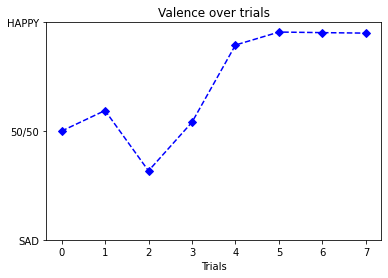

In [13]:
"""PLOT VALENCE ACROSS TRIALS"""
fig, ax = plt.subplots(1,1)
ax.plot(range(Trials), S2A[0,:], 'b--D')
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['SAD','50/50','HAPPY'])
ax.set_xlabel('Trials')
ax.set_title("Valence over trials")
plt.show()    

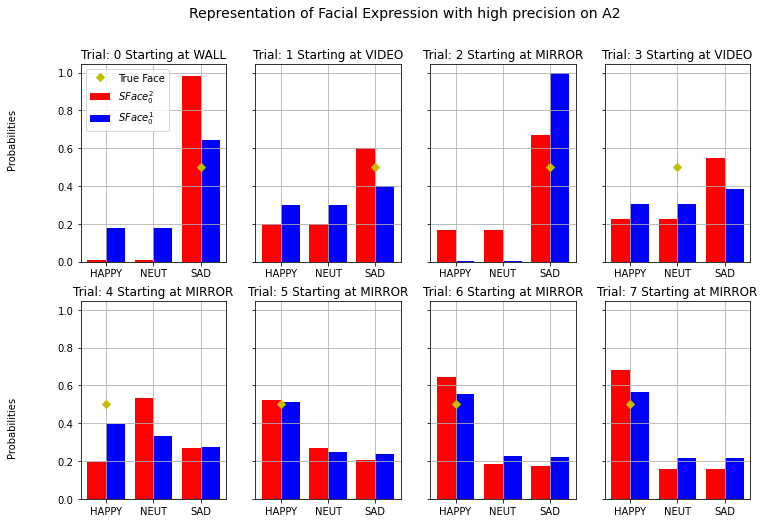

In [14]:
"""PLOT FIRST ORDER AND SECOND ORDER STATES"""
fig, axes = plt.subplots(2,4,sharey = True, figsize = (12,8))
count = 0
Actions = []
Locations = [location_observations[1]]
for loc in pols:
    Actions.append(location_observations[int(loc[0])])
    Locations.append(location_observations[int(loc[0])])
    

x_axis = np.arange(listFaceBMA[count].shape[0])
for i, ax in enumerate(axes):
    for j, _ in enumerate(ax):
        ax[j].grid()
        ax[j].bar(x_axis - 0.2, S2Face[:,count], width = 0.4, color='r', label = r'$SFace_0^{2}$')
        ax[j].bar(x_axis + 0.2, listFaceBMA[count], width = 0.4, color='b', label = r'$SFace_0^{1}$')
        ax[j].set_xticks([0,1,2])
        ax[j].set_xticklabels(['HAPPY','NEUT', 'SAD'])
        ax[j].set_title("Trial: " + str(count) + str(" Starting at ") + str(Locations[count]) )
        if TrueFaces[count]==2:
            ax[j].plot(2,0.5, 'yD', label = "True Face")
        elif TrueFaces[count]==0:
            ax[j].plot(0,0.5, 'yD', label = "True Face")
        else:    
            ax[j].plot(1,0.5, 'yD', label = "True Face")
        count += 1   
        
#plt.subplots_adjust(hspace = 1.3)
        
fig.text(0.04, 0.75, 'Probabilities', va='center', rotation='vertical')
fig.text(0.04, 0.25, 'Probabilities', va='center', rotation='vertical')
fig.suptitle("Representation of Facial Expression with high precision on A2", fontsize = 14)
axes[0][0].legend(loc = "upper left")
plt.show()      

